### We create a Convolutional Neural Network(CNN) for bangla digit recognition 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Define all the classes

Base Class for all layers: `Model`

In [3]:
class Model():
    def forward(self, x):
        pass
    def backward(self, x, y):
        pass

Create the `ConvolutionLayer` class

There will be four (hyper)parameters:
1. Number of output channels
2. Filter dimension
3. Stride
4. Padding

**Important resources**

`stride-tricks`
* [np.lib.stride_tricks.as_strided](https://jessicastringham.net/2017/12/31/stride-tricks/)
 
`np.einsum`
* [jessstringham/einsum.md](https://gist.github.com/jessstringham/5483028423c350d7b771d5c0482be246)
* [Basic guide to einsum](https://ajcr.net/Basic-guide-to-einsum/)
* [jessicastringam np.einsum](https://jessicastringham.net/2018/01/01/einsum/)


Backprop with strides:
* [Medium](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710)


In [4]:
class ConvolutionLayer(Model):
    def __init__(self, num_filters, filter_size, stride, padding):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        self.weights = None
        self.biases = None
        self.input = None
        self.cache = None

    def __str__(self):
        return f'Convolution Layer: {self.num_filters} filters of size {self.filter_size}x{self.filter_size} with stride {self.stride} and padding {self.padding}'
    
    def init_weights(self, num_channels):
        self.weights = np.random.randn(self.num_filters, num_channels, self.filter_size, self.filter_size) * \
                        np.sqrt(2 / (self.filter_size * self.filter_size * num_channels))
        
        self.biases = np.zeros(self.num_filters)

    def forward(self, input):
        # input has shape (batch_size, num_channels, input_height, input_width)
        n, c, h, w = input.shape
        output_height = (h + 2 * self.padding - self.filter_size ) // self.stride + 1
        output_width = (w + 2 * self.padding - self.filter_size ) // self.stride + 1
        output = np.zeros((n, self.num_filters, output_height, output_width))
        
        if self.weights is None:
            self.init_weights(c)

        # pad the input
        input_padded = np.pad(input, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)), 'constant')
                       
        batch_stride, channel_stride, height_stride, width_stride = input_padded.strides
        # print(f'batch_stride: {batch_stride}, channel_stride: {channel_stride}, height_stride: {height_stride}, width_stride: {width_stride}')
        strided_windows = np.lib.stride_tricks.as_strided(
            input_padded,
            shape = (n, c, output_height, output_width, self.filter_size, self.filter_size),
            strides = (batch_stride, channel_stride, height_stride * self.stride, width_stride * self.stride, height_stride, width_stride)
        )

        # print(f'strided_windows.shape: {strided_windows.shape}')
        # print(f'strided_windows:{strided_windows}')
        # print(f'weights:------------\n{self.weights}')
        # v = np.zeros((n, self.num_filters, output_height, output_width))
        # # implement forward with loop
        # for i in range(n):
        #     for j in range(self.num_filters):
        #         for k in range(output_height):
        #             for l in range(output_width):
        #                 v[i, j, k, l] = np.sum(input_padded[i, :, k*self.stride:k*self.stride+self.filter_size, l*self.stride:l*self.stride+self.filter_size] * self.weights[j, :, :, :]) + self.biases[j]


        output = np.einsum('bihwkl,oikl->bohw', strided_windows, self.weights) + self.biases[None, :, None, None]
        # print(f'output: {output}')
        
        # print(np.allclose(v, output))
        # print(f'output.shape: {output.shape}')
        self.cache = input, strided_windows
        
        return output

    def backward(self, dout, learning_rate):
    
        input, strided_windows = self.cache
        n, c, h, w = input.shape
        n, f, h_out, w_out = dout.shape

        padding = self.filter_size - 1 if self.padding == 0 else self.filter_size - 1 - self.padding
        dilate = self.stride - 1
        dout_dilated_padded = dout.copy()
        # print(f'dilate: {dilate}')
        # print(f'dout_dilated_padded:\n {dout_dilated_padded}')
        if dilate > 0:
            dout_dilated_padded = np.insert(dout_dilated_padded, range(1, dout.shape[2]), 0, axis=2)
            dout_dilated_padded = np.insert(dout_dilated_padded, range(1, dout.shape[3]), 0, axis=3)
             
        # print(f'dout_dilated_padded:\n {dout_dilated_padded}')
        
        if padding > 0:
            dout_dilated_padded = np.pad(dout_dilated_padded, ((0,0), (0,0), (padding, padding), (padding, padding)), 'constant')

        out_h, out_w = input.shape[2:] # output height and width
        out_b, out_c= dout.shape[:2] # output batch size and channel size
        batch_stride, channel_stride, height_stride, width_stride = dout_dilated_padded.strides

        dout_windows = np.lib.stride_tricks.as_strided(dout_dilated_padded, 
            shape = (out_b, out_c, out_h, out_w, self.filter_size, self.filter_size),
            strides = (batch_stride, channel_stride, height_stride * 1, width_stride * 1, height_stride, width_stride)
        )
        # print(f'dout_windows.shape: {dout_windows.shape}')
        # print(f'dout_windows: {dout_windows}')
        
        rotate_weights = np.rot90(self.weights, 2, (2, 3))

        dx = np.einsum('bohwkl, oikl -> bihw', dout_windows, rotate_weights)
        dw = np.einsum('bihwkl, bohw -> oikl', strided_windows, dout)
        db = np.sum(dout, axis=(0, 2, 3))

        # print(dout.shape)
        

        self.weights -= learning_rate * dw
        self.biases -= learning_rate * db
        

        return dx
    
    
        


Test the class

In [5]:
count = 1*1*5*5
input_arr = np.arange(-count/2, count/2).reshape(1, 1, 5, 5)
# print(f'input: {input_arr}\n')
conv_layer = ConvolutionLayer(num_filters=1, filter_size= 3, stride= 1, padding= 0)
print(conv_layer)
output = conv_layer.forward(input_arr)
print(output.shape)
print(f'output--------\n{output}\n')
back = conv_layer.backward(output, 0.01)
print(back.shape)
print(f'back--------\n{back}\n')
# print(output[0, 0, :, :])

Convolution Layer: 1 filters of size 3x3 with stride 1 and padding 0
(1, 1, 3, 3)
output--------
[[[[-7.65724892 -7.34438154 -7.03151415]
   [-6.09291201 -5.78004462 -5.46717724]
   [-4.52857509 -4.21570771 -3.90284033]]]]

(1, 1, 5, 5)
back--------
[[[[ 0.17911449 -0.11177131 -4.86488839 -4.82339785 -4.36862113]
   [-0.28728301 -1.32363021 -5.4371973  -4.91522076 -3.74883998]
   [ 0.83239    -1.19909087 -0.048943   -0.68320758  1.16648195]
   [ 0.59598634 -0.85227393  2.32562937  1.7071634   2.80974142]
   [ 0.63189704 -0.10792319  2.38577754  1.71731237  2.14530769]]]]



Create the **ReLU Activation** as `ActivationLayer`

In [6]:
class ActivationLayer(Model):
    def __init__(self):
        self.input = None

    def __str__(self):
        return 'ReLU Activation Layer'

    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

    def backward(self, dL_dout, learning_rate):
        return dL_dout * (self.input > 0)


Test Activation

In [7]:
activation = ActivationLayer()
print(output)
a = activation.forward(output)
print(a)
b = activation.backward(a, 0.01)
print(b)

[[[[-7.65724892 -7.34438154 -7.03151415]
   [-6.09291201 -5.78004462 -5.46717724]
   [-4.52857509 -4.21570771 -3.90284033]]]]
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


>Max-pooling: There will be two parameters:
> 1. Filter dimension
> 2. Stride

Create the Max-Pooling layer as `MaxPoolingLayer`

In [8]:
class PoolingLayer(Model):
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.input = None

    def __str__(self):
        return f'Pooling Layer (pool_size={self.pool_size}, stride={self.stride})'


    def forward(self, input):
        self.input = input
        n, c, h, w = input.shape
        output_height = (h - self.pool_size) // self.stride + 1
        output_width = (w - self.pool_size) // self.stride + 1
       
        batch_stride, channel_stride, height_stride, width_stride = input.strides
        input_windows = np.lib.stride_tricks.as_strided(input,
            shape = (n, c, output_height, output_width, self.pool_size, self.pool_size),
            strides = (batch_stride, channel_stride, height_stride * self.stride, width_stride * self.stride, height_stride, width_stride)
        )
        output = np.max(input_windows, axis=(4, 5))
        
        if self.stride == self.pool_size:
            mask = output.repeat(self.stride, axis=-2).repeat(self.stride, axis=-1)
            # print(f'shape of mask after repeat: {mask.shape}')
            # print(f'mask: {mask}')
            # pad for odd shape
            h_pad = h - mask.shape[-2]
            w_pad = w - mask.shape[-1]
            mask = np.pad(mask, ((0,0), (0,0), (0, h_pad), (0, w_pad)), 'constant')
            # print(f'shape of mask after pad: {mask.shape}')
            # print(f'mask: {mask}')
            mask = np.equal(input, mask)
            # print(f'shape of mask after equal: {mask.shape}')
            # print(f'mask: {mask}')

            self.cache = mask
        return output

    def backward(self, dL_dout, learning_rate):
        n, c, h, w = self.input.shape
        h_out, w_out = dL_dout.shape[-2:]
        
        stride = self.stride
        if stride == self.pool_size:
            dL_dout = dL_dout.repeat(stride, axis=-2).repeat(stride, axis=-1)
            mask = self.cache
            # pad for odd shape
            h_pad = h - dL_dout.shape[-2]
            w_pad = w - dL_dout.shape[-1]
            dL_dout = np.pad(dL_dout, ((0,0), (0,0), (0, h_pad), (0, w_pad)), 'constant')
            # print(f'shape of dL_dout after pad: {dL_dout.shape}')
            return dL_dout * mask
            
        else:
            dx = np.zeros(self.input.shape)

            for i in range(n):
                for j in range(c):
                    for k in range(h_out):
                        for l in range(w_out):
                            
                            i_t, j_t = np.where(np.max(self.input[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size]) == self.input[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size])
                            i_t, j_t = i_t[0], j_t[0]
                            
                            dx[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size][i_t, j_t] = dL_dout[i, j, k, l]
           
        
        return dx

In [9]:
%time
pool = PoolingLayer(2, 2)
print(f'a.shape: {a.shape}\n')
print(f'After ReLU Activation\n{a}')
p = pool.forward(a)
print(f'After Max Pool\n{p}')
b = pool.backward(p, 0.01)
print(f'After Max Pool Backprop\n{b}')
print(f'b.shape: {b.shape}\n')

CPU times: total: 0 ns
Wall time: 0 ns
a.shape: (1, 1, 3, 3)

After ReLU Activation
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
After Max Pool
[[[[0.]]]]
After Max Pool Backprop
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
b.shape: (1, 1, 3, 3)



> Flattening layer: it will convert a (series of) convolutional filter maps to a column vector.

Create the Flattening Layer as `FlatteningLayer`

In [10]:
class FlatteningLayer(Model):
    def __init__(self):
        self.input = None

    def __str__(self):
        return "Flattening Layer"

    def forward(self, input):
        self.input = input
        batch_size = input.shape[0]
        return np.reshape(input, (batch_size, -1))

    def backward(self, dL_dout, learning_rate):
        return np.reshape(dL_dout, self.input.shape)

In [11]:
f = FlatteningLayer()
flat = f.forward(p)
print(flat)
flat.shape

[[0.]]


(1, 1)

> Fully-connected layer: a dense layer. There will be one parameter: output dimension

Create fully-connected Layer as `FullyConnectedLayer`

In [12]:
class FullyConnectedLayer(Model):
    def __init__(self, output_dim):
        self.weights = None
        self.biases = None
        self.input = None
        self.output_dim = int(output_dim)
        
    
    def __str__(self):
        return f'Fully Connected Layer (output_dim={self.output_dim})'

    def forward(self, input):
        self.input = input
        batch_size = input.shape[0]
        if self.weights is None:
            self.weights = np.random.randn(input.shape[1], self.output_dim) * np.sqrt(2 / input.shape[1])
            self.biases = np.zeros(self.output_dim)
        return np.dot(input, self.weights) + self.biases

    def backward(self, dL_dout, learning_rate):
        dL_dW = np.dot(self.input.T, dL_dout)
        dL_db = np.sum(dL_dout, axis=0)
        dL_din = np.dot(dL_dout, self.weights.T)

        self.weights -= learning_rate * dL_dW
        self.biases -= learning_rate * dL_db

        return dL_din
    

In [13]:
# Write code to test fully connected layer implementation
fc = FullyConnectedLayer(10)
fc_out = fc.forward(flat)
print(fc_out)
fc_back = fc.backward(fc_out, 0.01)
print(fc_back)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.]]


In [14]:
fc = FullyConnectedLayer(2)
fc_out = fc.forward(flat)
print(fc_out)

[[0. 0.]]


> Softmax: it will convert final layer projections to normalized probabilities.

Create the `SoftMaxLayer`

In [15]:
class SoftMaxLayer(Model):
    def __init__(self):
        self.input = None

    def __str__(self):
        return 'Softmax Layer'

    def forward(self, input):
        self.input = input
        # print(f'inputs: {input}\nmax:{np.max(input, axis=1, keepdims=True)}')
        # print(f'exp:{np.exp(input)}\nsubtracted:{np.exp(input - np.max(input, axis=1, keepdims=True))}')
        exps = np.exp(input - np.max(input, axis=1, keepdims=True))
        # print(f'exps = {exps}')
        return exps / np.sum(exps, axis=1, keepdims=True)

    def backward(self, dL_dout, learning_rate):
        return dL_dout

In [16]:
smax = SoftMaxLayer()
smax_out = smax.forward(fc_out)
print(smax_out)

[[0.5 0.5]]


# Import and vectorize Data

In [25]:
image_count = 200000

def load_images(folder_path, count):
    images = []
    i = 0
    for filename in sorted(os.listdir(folder_path)):
        # load the image using OpenCV
        try:
            img = cv2.imread(os.path.join(folder_path, filename))
            # compress image pixels
            img = cv2.resize(img, (28, 28))
            # convert the image from BGR to RGB format
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # convert the image to a NumPy array of shape (channel, height, width)
            img = (255 - np.transpose(img, (2, 0, 1))) / 255
            # img = cv2.dilate(img, np.ones((2, 2), np.uint8))
            
            images.append(img)
            i +=1
            if i == count:
                break
        except:
            pass
    return images


### View some samples

In [26]:
# images = load_images('data/training-b/', image_count)
images = load_images('data/training-a/', image_count)
images += load_images('data/training-b/', image_count)
images += load_images('data/training-c/', image_count)
print(len(images))
# show an image
# print(images[0][ 0, 24:48, 24:48])


44359


(3, 28, 28)


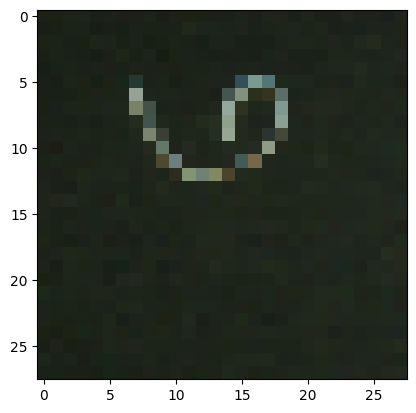

In [27]:
# Show an Image
img_idx = 1
plt.imshow(images[img_idx].transpose(1, 2, 0))
print(images[img_idx].shape)

Load `y`

In [28]:
# load y from csv file
# y = np.loadtxt('data/training-b.csv', delimiter=',', skiprows=1, usecols=3, max_rows= image_count, dtype=int)
y = np.loadtxt('data/training-a.csv', delimiter=',', skiprows=1, usecols=3, max_rows= image_count, dtype=int)
y = np.concatenate([y, np.loadtxt('data/training-b.csv', delimiter=',', skiprows=1, usecols=3, max_rows= image_count, dtype=int)])
y = np.concatenate([y, np.loadtxt('data/training-c.csv', delimiter=',', skiprows=1, usecols=3, max_rows=image_count, dtype=int)])
# y = np.concatenate([y,y2])
y.shape

(44359,)

## Build Model

In [29]:
# get model data from model.txt and build model

class ModelBuilder:
    def __init__(self):
        self.model = []

    def __str__(self):
        # call __str__ of each layer in model
        info = "Model: \n"
        for layer in self.model:
            info += layer.str() + "\n"
        return info


    def build(self):
        model = self.model

        model.append(ConvolutionLayer(6, 5, 1, 0))
        model.append(ActivationLayer())
        model.append(PoolingLayer(2, 2))
        model.append(ConvolutionLayer(16, 5, 1, 0))
        model.append(ActivationLayer())
        model.append(PoolingLayer(2, 2))
        model.append(FlatteningLayer())
        model.append(FullyConnectedLayer(120))
        model.append(ActivationLayer())
        model.append(FullyConnectedLayer(84))
        model.append(ActivationLayer())
        model.append(FullyConnectedLayer(10))
        model.append(SoftMaxLayer())


        return self.model



# Train Model

In [30]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss, f1_score
# train model having X_train, y_train, X_val, y_val, learning_rate, epochs, batch_size, y is one hot encoded
def train(model, X_train, y_train, X_val, y_val, learning_rate, epochs, batch_size):
# initialize loss and accuracy lists
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    val_f1 = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        # shuffle training data
        idx = np.random.permutation(len(X_train))
        X_train = X_train[idx]
        y_train = y_train[idx]

        # get number of batches
        num_batches = len(X_train) // batch_size
        loss = 0
        acc = 0
        for i in tqdm(range(num_batches)):
            X_batch = X_train[i * batch_size:(i + 1) * batch_size]
            y_batch = y_train[i * batch_size:(i + 1) * batch_size]
            # print(X_batch.shape, y_batch.shape)
            
            # forward pass
            out = X_batch
            for layer in model:
                out = layer.forward(out)
            # print(f'out.shape: {out.shape}')
            # print(f'out: {out}')
            
            loss += log_loss(y_batch, out)

            # calculate accuracy
            acc += accuracy_score(np.argmax(y_batch, axis=1), np.argmax(out, axis=1))

            # backward pass
            dL_dout = np.copy(out)
            dL_dout -= y_batch
            dL_dout /= batch_size
            for layer in reversed(model):
                dL_dout = layer.backward(dL_dout, learning_rate)
            
        train_loss.append(loss/num_batches)
        train_acc.append(acc/num_batches)
        # validation
        
        val_out = X_val
        for layer in model:
            val_out = layer.forward(val_out)
        val_loss.append(log_loss(y_val, val_out))
        val_acc.append(accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_out, axis=1)))
        curr_f1 = f1_score(np.argmax(y_val, axis=1), np.argmax(val_out, axis=1), average='macro')
        val_f1.append(curr_f1)
        print(f'learning_rate: {learning_rate}')

        print(f'Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f}')
        print(f'Val Loss: {val_loss[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}')
        print(f'Val F1: {val_f1[-1]:.4f}')

        

    return train_loss, train_acc, val_loss, val_acc


Create train-test sets

In [31]:
# create train, validation data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, y, test_size=0.15, random_state=42)
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.eye(10)[y_train].astype(int)
y_val = np.eye(10)[y_val].astype(int)

# print shapes of train, validation data with messages
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')  
print(f'y_val shape: {y_val.shape}')

X_train shape: (37705, 3, 28, 28)
y_train shape: (37705, 10)
X_val shape: (6654, 3, 28, 28)
y_val shape: (6654, 10)


Train the model

In [24]:
model = ModelBuilder().build()
print(model)

[<__main__.ConvolutionLayer object at 0x000002BA409B1BA0>, <__main__.ActivationLayer object at 0x000002BA409B1CC0>, <__main__.PoolingLayer object at 0x000002BA409B1DB0>, <__main__.ConvolutionLayer object at 0x000002BA409B29E0>, <__main__.ActivationLayer object at 0x000002BA409B2A10>, <__main__.PoolingLayer object at 0x000002BA409B28C0>, <__main__.FlatteningLayer object at 0x000002BA409B1000>, <__main__.FullyConnectedLayer object at 0x000002BA409B28F0>, <__main__.ActivationLayer object at 0x000002BA409B1090>, <__main__.FullyConnectedLayer object at 0x000002BA409B1A20>, <__main__.ActivationLayer object at 0x000002BA409B2950>, <__main__.FullyConnectedLayer object at 0x000002BA409B0F70>, <__main__.SoftMaxLayer object at 0x000002BA409B0EB0>]


In [186]:
history = train(model, X_train, y_train, X_val, y_val, learning_rate=0.01, epochs=10, batch_size=32)

Epoch 1/10


100%|██████████| 62/62 [00:13<00:00,  4.49it/s]


learning_rate: 0.01
Train Loss: 2.3101 | Train Acc: 0.1159
Val Loss: 2.3057 | Val Acc: 0.1102
Val F1: 0.0838
Epoch 2/10


100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


learning_rate: 0.01
Train Loss: 2.2797 | Train Acc: 0.1371
Val Loss: 2.2814 | Val Acc: 0.1497
Val F1: 0.1363
Epoch 3/10


100%|██████████| 62/62 [00:17<00:00,  3.65it/s]


learning_rate: 0.01
Train Loss: 2.2590 | Train Acc: 0.1709
Val Loss: 2.2637 | Val Acc: 0.1723
Val F1: 0.1536
Epoch 4/10


100%|██████████| 62/62 [00:19<00:00,  3.24it/s]


learning_rate: 0.01
Train Loss: 2.2366 | Train Acc: 0.2137
Val Loss: 2.2387 | Val Acc: 0.2119
Val F1: 0.2005
Epoch 5/10


100%|██████████| 62/62 [00:21<00:00,  2.91it/s]


learning_rate: 0.01
Train Loss: 2.2064 | Train Acc: 0.2450
Val Loss: 2.2085 | Val Acc: 0.2260
Val F1: 0.2071
Epoch 6/10


100%|██████████| 62/62 [00:17<00:00,  3.47it/s]


learning_rate: 0.01
Train Loss: 2.1692 | Train Acc: 0.2792
Val Loss: 2.1721 | Val Acc: 0.2458
Val F1: 0.2410
Epoch 7/10


100%|██████████| 62/62 [00:18<00:00,  3.36it/s]


learning_rate: 0.01
Train Loss: 2.1175 | Train Acc: 0.3080
Val Loss: 2.1257 | Val Acc: 0.2740
Val F1: 0.2694
Epoch 8/10


100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


learning_rate: 0.01
Train Loss: 2.0520 | Train Acc: 0.3281
Val Loss: 2.0642 | Val Acc: 0.2966
Val F1: 0.2877
Epoch 9/10


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


learning_rate: 0.01
Train Loss: 1.9760 | Train Acc: 0.3589
Val Loss: 1.9999 | Val Acc: 0.3192
Val F1: 0.3180
Epoch 10/10


100%|██████████| 62/62 [00:17<00:00,  3.53it/s]


learning_rate: 0.01
Train Loss: 1.9038 | Train Acc: 0.3700
Val Loss: 1.9595 | Val Acc: 0.3446
Val F1: 0.3440


In [188]:
from sklearn.metrics import f1_score
y_pred = X_val
for layer in model:
    y_pred = layer.forward(y_pred)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
f1_score(y_true, y_pred, average='macro')

0.3440410651860205

View `loss` and `accuracy`

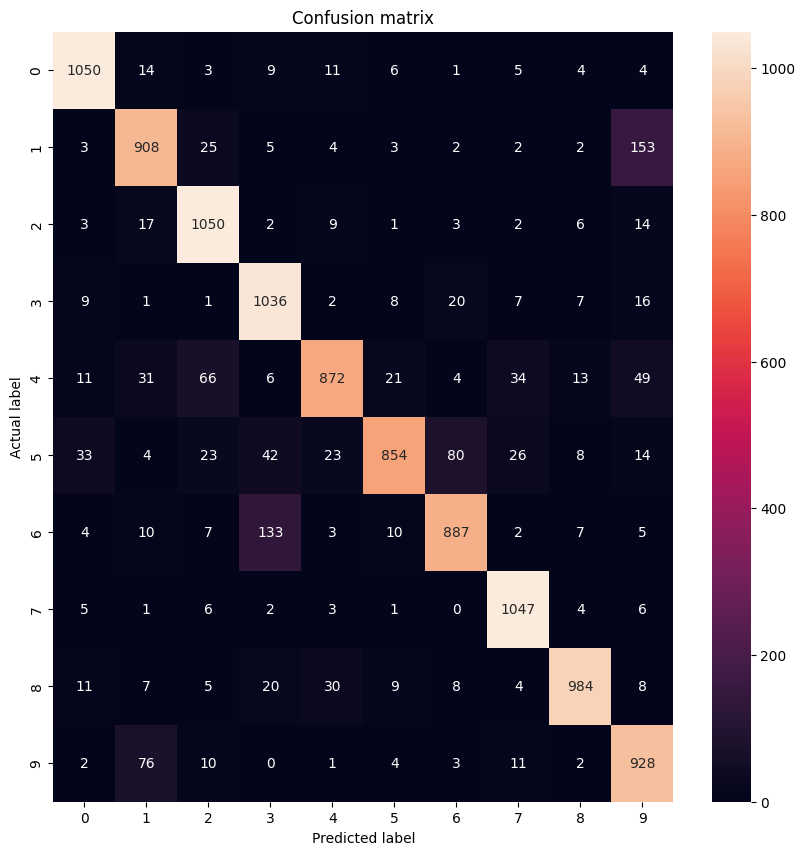

In [51]:
# plt.plot(history[0], label='train loss')
# plt.plot(history[2], label='validation loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # show train, validation accuracy
# plt.plot(history[1], label='train accuracy')
# plt.plot(history[3], label='validation accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(labels, out)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Save Model and params

In [33]:
import pickle

### Save only model weights and bias

In [77]:

model_weights_biases = []
for layer in model:
    if hasattr(layer, 'weights'):
        model_weights_biases.append(layer.weights)
        model_weights_biases.append(layer.biases)

with open('model_weights_biases_92val.pkl', 'wb') as f:
    pickle.dump(model_weights_biases, f)

### Load Model weights and biases

In [44]:
# load model weights and bias
with open('model_weights_biases_88tst.pkl', 'rb') as f:
    model_weights_biases = pickle.load(f)

# len(model_weights)
# set model weights and bias
i = 0
for layer in model:
    if hasattr(layer, 'weights'):
        # print(layer)
        layer.weights = model_weights_biases[i * 2]
        layer.biases = model_weights_biases[i * 2 + 1]
        i += 1

Check if model is same

In [45]:
from sklearn.metrics import f1_score
y_pred = X_val
for layer in model:
    y_pred = layer.forward(y_pred)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
f1_score(y_true, y_pred, average='macro')

0.9182105157016147

In [46]:
accuracy_score(y_true, y_pred)

0.9182446648632402

In [47]:
# save model
import pickle
with open('model_88tst.pkl', 'wb') as f:
    pickle.dump(model, f)

In [60]:
with open('model_88tst.pkl', 'rb') as f:
    model = pickle.load(f)

Test saved model

In [39]:
# load test images
def load_test_images(folder_path):
    images = []
    i = 0
    for filename in sorted(os.listdir(folder_path)):
        # load the image using OpenCV
        try: 
            img = cv2.imread(os.path.join(folder_path, filename))
            # compress image pixels
            
            img = cv2.resize(img, (28, 28))
            # convert the image from BGR to RGB format
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # convert the image to a NumPy array of shape (channel, height, width)
            img = (255 - np.transpose(img, (2, 0, 1))) / 255
            # img = cv2.dilate(img, np.ones((2, 2), np.uint8))
            images.append(img)
            i+=1
            if i == 100000:
                break
        except:
            print(filename)
    return np.array(images)


In [40]:
def load_labels(filepath):
    labels = np.loadtxt(filepath, delimiter=',', skiprows=1, usecols=2, max_rows=100000, dtype=int)
    return labels

In [41]:
# get test data
test_images = load_test_images('data/training-d/')
labels = load_labels('data/training-d.csv')
print(f'Number of test images: {len(test_images)}')
print(f'Number of labels: {len(labels)}')

Number of test images: 10908
Number of labels: 10908


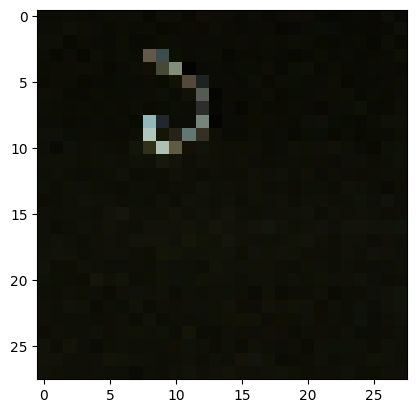

1


In [48]:
# view an image
plt.imshow(np.transpose(test_images[0], (1, 2, 0)))
plt.show()
print(labels[0])

### Inference

In [49]:
from sklearn.metrics import accuracy_score, f1_score
out = test_images
for layer in model:
    out = layer.forward(out)

# get predicted labels
out = np.argmax(out, axis=1)
labels = np.array(labels)
accuracy = accuracy_score(labels, out)
f1_score = f1_score(labels, out, average='macro')
# # view predicted labels

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1_score:.4f}')

Accuracy: 0.8816
F1 Score: 0.8808
